In [1]:
# 1. Các thư viện cần thiết
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
# 2. Đọc file dữ liệu chứng khoán Eximbank và chia tập train test theo tỉ lệ 9:1
df = pd.read_csv('Eximbank.csv')
df = df[['Close', 'High']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

train_size = int(0.9 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [3]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Tìm mô hình ARIMA phù hợp nhất bằng auto_arima 
auto_arima(train_data['Close'], trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17631.159, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17642.063, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17631.298, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17632.400, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17640.196, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17630.696, Time=0.66 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17631.437, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17629.076, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17630.681, Time=0.47 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17630.766, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=17627.142, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=17630.503, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=17629.396, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=17628.743, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [4]:
model = VARMAX(train_data, order=(1, 1))
model_fit = model.fit(maxiter=1000, disp=False)

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [5]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
close_pred = model_fit.forecast(steps=len(y_test))
y_pred = close_pred['Close'].to_numpy()

In [7]:
# 5. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Tạo một mảng gồm 90 số nguyên liên tiếp bắt đầu từ last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

# Dự đoán giá đóng cho 90 ngày tiếp theo
close_next_90_days = model_fit.forecast(steps=len(x_next_90_days))

y_next_90_days = close_next_90_days['Close'].to_numpy()

# In ra giá đóng đã được dự đoán trong 90 ngày tiếp theo
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
[17710.71262949 17707.97519408 17703.74942363 17698.74727328
 17693.34195563 17687.72910925 17682.01128564 17676.24223867
 17670.45014171 17664.64975847 17658.8488231  17653.05138475
 17647.25956087 17641.47445627 17635.69664491 17629.92642253
 17624.16393896 17618.4092676  17612.66244178 17606.92347383
 17601.19236506 17595.46911104 17589.75370432 17584.04613588
 17578.34639588 17572.65447407 17566.97035995 17561.29404297
 17555.62551249 17549.96475787 17544.31176846 17538.66653361
 17533.0290427  17527.3992851  17521.77725021 17516.16292744
 17510.5563062  17504.95737593 17499.36612609 17493.78254613
 17488.20662553 17482.6383538  17477.07772042 17471.52471494
 17465.97932688 17460.44154579 17454.91136124 17449.38876281
 17443.87374009 17438.3662827  17432.86638024 17427.37402236
 17421.88919872 17416.41189896 17410.94211278 17405.47982987
 17400.02503993 17394.57773268 17389.13789786 17383.70552523
 17378.28060453 17372.86312556 17367.4

In [8]:
# 6. Tính độ đo RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 1235.1683021085216


In [9]:
# 7. Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))*100
print('Testing MAPE:', test_mape)

Testing MAPE: 5.877872144946972


In [10]:
# 8. Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - y_test))
print('Testing MAE:', test_mae)

Testing MAE: 1100.2448006692068


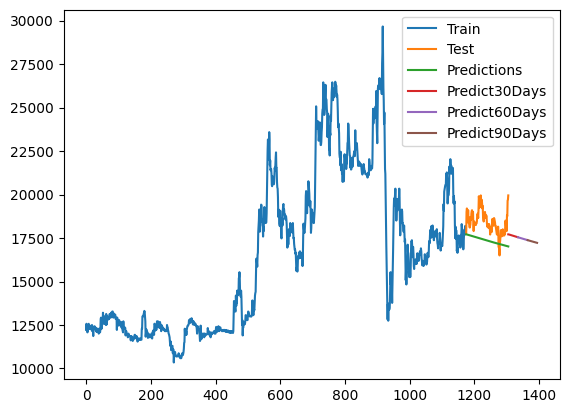

In [11]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data[0:30],y_next_90_days[0:30])
plt.plot(last_data[30:60],y_next_90_days[30:60])
plt.plot(last_data[60:90],y_next_90_days[60:90])
plt.legend(['Train', 'Test', 'Predictions','Predict30Days', 'Predict60Days', 'Predict90Days'])
plt.show()

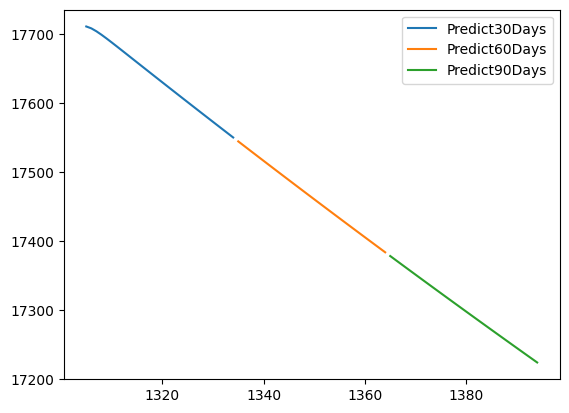

In [12]:
plt.plot(last_data[0:30],y_next_90_days[0:30])
plt.plot(last_data[30:60],y_next_90_days[30:60])
plt.plot(last_data[60:90],y_next_90_days[60:90])
plt.legend(['Predict30Days', 'Predict60Days', 'Predict90Days'])
plt.show()